<a href="https://colab.research.google.com/github/KelllyChen/2025-Fall-XAI-Explainable-Deep-Learning/blob/notebook/AIPI_590_XAI_%7C_Explainable_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Explainable Deep Learning
- Used a pretrained ResNet-18 model on healthy and pneumonia-affected chest X-rays
- Implemented GradCAM and two of its variants, XGradCAM and EigenCAM to 10 images
- Generated and presented visualizations showing what regions of the image the model is focusing on for its predictions.
- Wrote a reflection on these XAI techniques.

# Install and import packages

In [1]:
!pip install datasets

In [2]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=797777603c7cc933284941c966e86d95544273da89681280c4723849c29ab253
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [3]:
from huggingface_hub import hf_hub_download
import zipfile
import os
from datasets import load_dataset
import torch
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import copy
from PIL import Image
import torchvision
from torchvision import transforms
from pytorch_grad_cam import GradCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

# Download and extract data from huggingface
- The original data was collected from here: [Chest X-Ray Images (Normal and Pneumonia)](https://www.kaggle.com/datasets/ghost5612/chest-x-ray-images-normal-and-pneumonia)

- I downloaded and uploaded it to Hugging Face under MIT license, data can be found here: [Chest-X-Ray-Images](https://huggingface.co/datasets/kellly/Chest-X-Ray-Images)




In [4]:
# Download files from huggingface
data_path = hf_hub_download(
    repo_id="kellly/Chest-X-Ray-Images",
    filename="chest_xray.zip",
    repo_type="dataset"
)

print("Files:", data_path)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


chest_xray.zip:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

Files: /root/.cache/huggingface/hub/datasets--kellly--Chest-X-Ray-Images/snapshots/beb98784b8ab57eb069b4d07f542e666090f594d/chest_xray.zip


In [5]:
extract_dir = "./chest_xray"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extracted to:", extract_dir)


Extracted to: ./chest_xray


# Data Overview

- Total images: 5,863
- Categories: Normal and Pneumonia
- Source: Pediatric patients (ages 1–5) from Guangzhou Women and Children’s Medical Center
- Structure: Organized into train, test, and validation folders, with subfolders for each class

In [6]:
train_dir = "/content/chest_xray/chest_xray/train"

normal_count = len(os.listdir(os.path.join(train_dir, "NORMAL")))
pneumonia_count = len(os.listdir(os.path.join(train_dir, "PNEUMONIA")))

print("Training Set:")
print("NORMAL:", normal_count)
print("PNEUMONIA:", pneumonia_count)

Training Set:
NORMAL: 1341
PNEUMONIA: 3875


Label: Normal


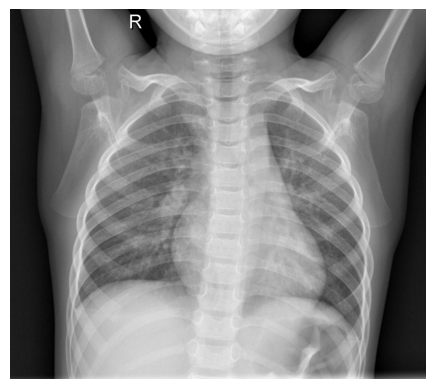

In [7]:
img_path = "/content/chest_xray/chest_xray/train/NORMAL/IM-0115-0001.jpeg"

# Open image
img = Image.open(img_path).convert("L")
print("Label: Normal")

# Show with matplotlib
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()


Label: Pneumonia


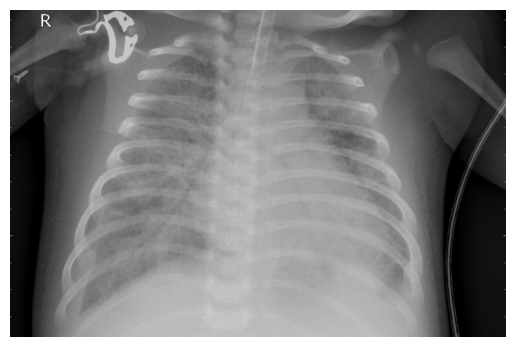

In [8]:
img_path = "/content/chest_xray/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg"

# Open image
img = Image.open(img_path).convert("L")
print("Label: Pneumonia")

# Show with matplotlib
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()


# Pre-trained ResNet-18 model
The following code is referenced and modified from [here](https://medium.com/@imabhi1216/fine-tuning-a-pre-trained-resnet-18-model-for-image-classification-on-custom-dataset-with-pytorch-02df12e83c2c).


In [9]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


In [10]:
# Modify the last layer of the model
num_classes = 2 # Normal/ Pneumonia
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

In [11]:
# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the train and validation datasets
train_dataset = ImageFolder('/content/chest_xray/chest_xray/train', transform=transform)
val_dataset = ImageFolder('/content/chest_xray/chest_xray/val', transform=transform)
test_dataset = ImageFolder('/content/chest_xray/chest_xray/test', transform=transform)



train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

In [13]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience=3):
    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    best_val_acc = 0.0
    patience_counter = 0
    best_model_wts = copy.deepcopy(model.state_dict())


    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()

        # Initialize running loss and correct predictions count for training
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the training data loader
        for inputs, labels in train_loader:
            # Move inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Reset the gradients to zero before the backward pass
            optimizer.zero_grad()

            # Forward pass: compute the model output
            outputs = model(inputs)
            # Get the predicted class (with the highest score)
            _, preds = torch.max(outputs, 1)

            # Compute the loss between the predictions and actual labels
            loss = criterion(outputs, labels)

            # Backward pass: compute gradients
            loss.backward()
            # Perform the optimization step to update model parameters
            optimizer.step()

            # Accumulate the running loss and the number of correct predictions
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)


        # Compute average training loss and accuracy for this epoch
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.float() / len(train_loader.dataset)


        # Set the model to evaluation mode for validation
        model.eval()
        # Initialize running loss and correct predictions count for validation
        running_loss = 0.0
        running_corrects = 0

        # Disable gradient computation for validation
        with torch.no_grad():
            # Iterate over the validation data loader
            for inputs, labels in val_loader:
                # Move inputs and labels to the device (GPU or CPU)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass: compute the model output
                outputs = model(inputs)
                # Get the predicted class (with the highest score)
                _, preds = torch.max(outputs, 1)

                # Compute the loss between the predictions and actual labels
                loss = criterion(outputs, labels)

                # Accumulate the running loss and the number of correct predictions
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


        # Compute average validation loss and accuracy for this epoch
        val_loss = running_loss / len(val_loader.dataset)
        val_acc = running_corrects.float() / len(val_loader.dataset)


        # Print the results for the current epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, val loss: {val_loss:.4f}, val acc: {val_acc:.4f}')

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            # Save the best weight
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
    model.load_state_dict(best_model_wts)
    return model



In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [15]:
model = model.to(device)
model = train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3)

Epoch [1/10], train loss: 0.2468, train acc: 0.9055, val loss: 0.4628, val acc: 0.7660
Epoch [2/10], train loss: 0.1469, train acc: 0.9452, val loss: 0.4978, val acc: 0.7660
Epoch [3/10], train loss: 0.1327, train acc: 0.9503, val loss: 0.6565, val acc: 0.7447
Epoch [4/10], train loss: 0.1244, train acc: 0.9548, val loss: 0.4415, val acc: 0.7872
Epoch [5/10], train loss: 0.1315, train acc: 0.9486, val loss: 0.6059, val acc: 0.7447
Epoch [6/10], train loss: 0.1203, train acc: 0.9530, val loss: 0.4661, val acc: 0.7660
Epoch [7/10], train loss: 0.1147, train acc: 0.9569, val loss: 0.4394, val acc: 0.7660
Early stopping triggered.


# Model Evaluation

In [16]:
def evaluate_model(model, test_loader, device):
    # Initialize dictionaries to store correct and total predictions
    correct_pred = {classname: 0 for classname in test_loader.dataset.classes}
    total_pred = {classname: 0 for classname in test_loader.dataset.classes}

    # Set the model to evaluation mode
    model.eval()

    # Track the ground truth labels and predictions
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)


            # Collect predictions and labels for metric calculations
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            # Update the correct and total predictions
            for label, prediction in zip(labels, preds):
                classname = test_loader.dataset.classes[label]
                if label == prediction:
                    correct_pred[classname] += 1
                total_pred[classname] += 1

    # Calculate accuracy per class
    accuracy_per_class = {classname: correct_pred[classname] / total_pred[classname] if total_pred[classname] > 0 else 0
                          for classname in test_loader.dataset.classes}

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(all_labels, all_preds)


    # Print the evaluation results
    print("Accuracy per class:")
    for classname, accuracy in accuracy_per_class.items():
        print(f"{classname}: {accuracy:.4f}")

    print()
    print(f"Overall Accuracy: {overall_accuracy:.4f}")



evaluate_model(model, test_loader, device)

Accuracy per class:
NORMAL: 0.5726
PNEUMONIA: 0.9872

Overall Accuracy: 0.8317


# GradCAM/ XGradCAM/ EigenCAM

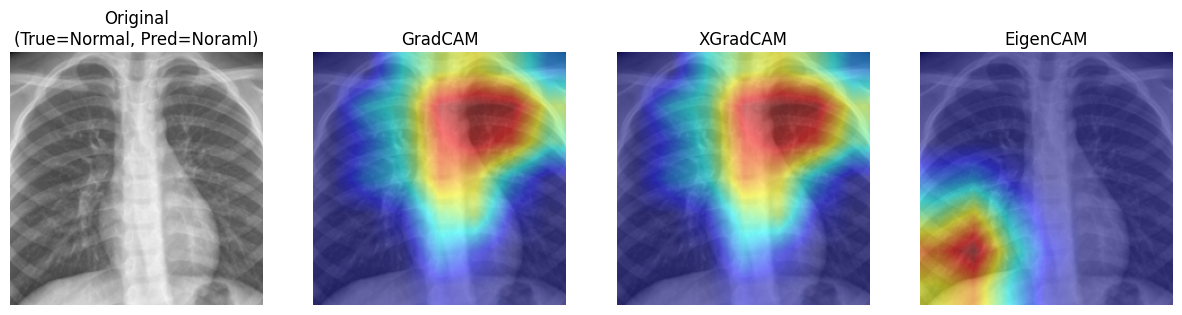

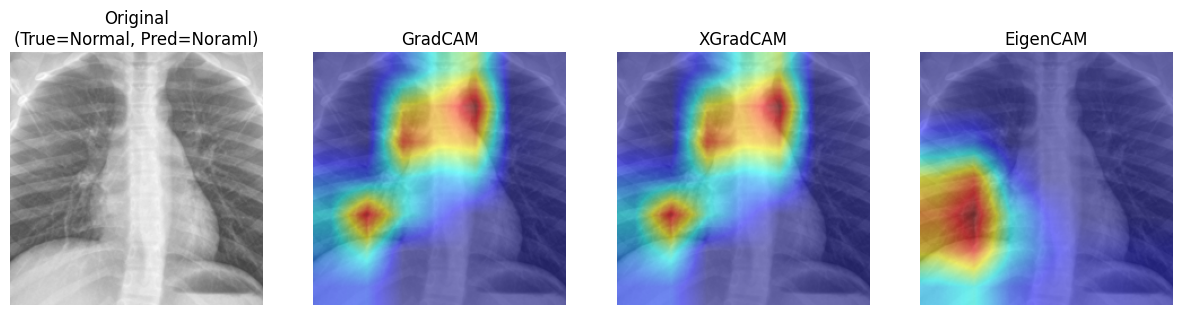

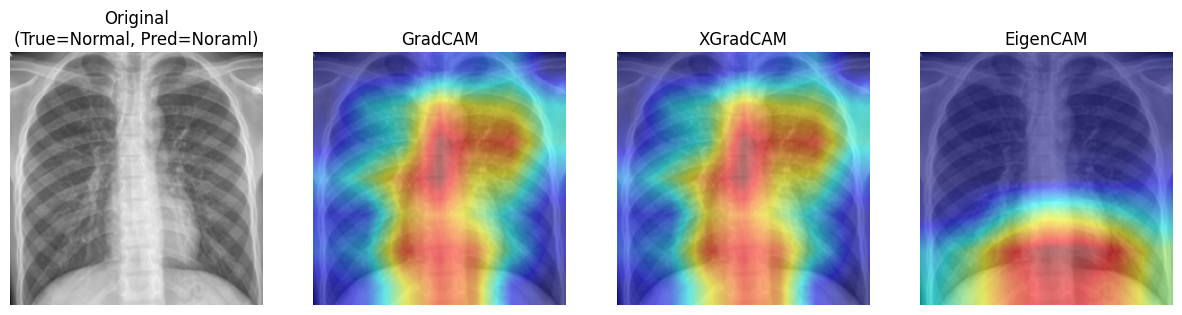

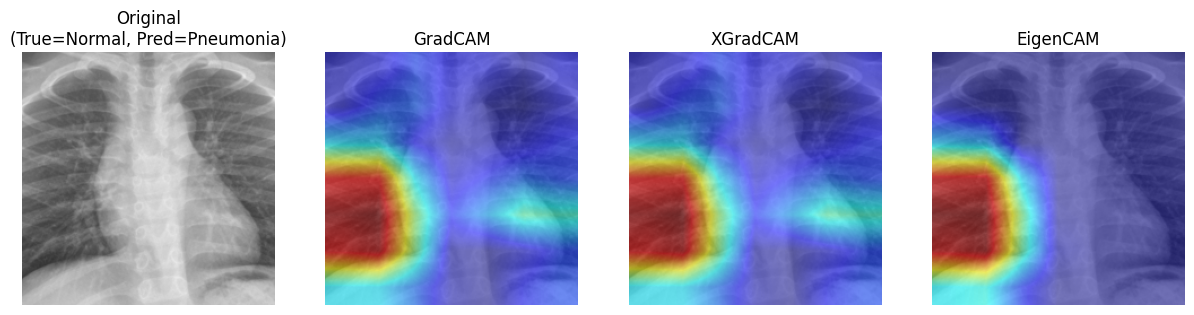

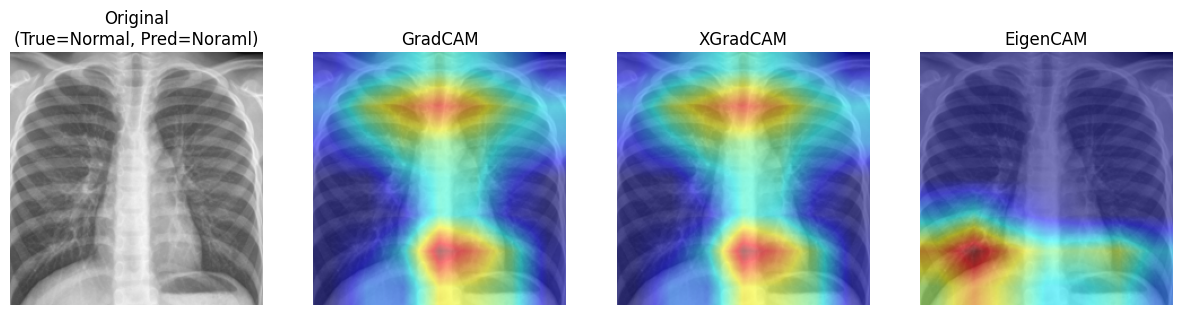

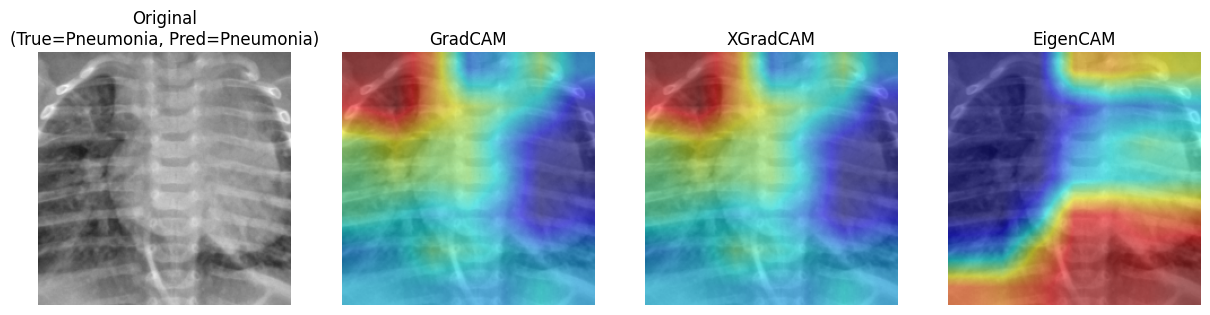

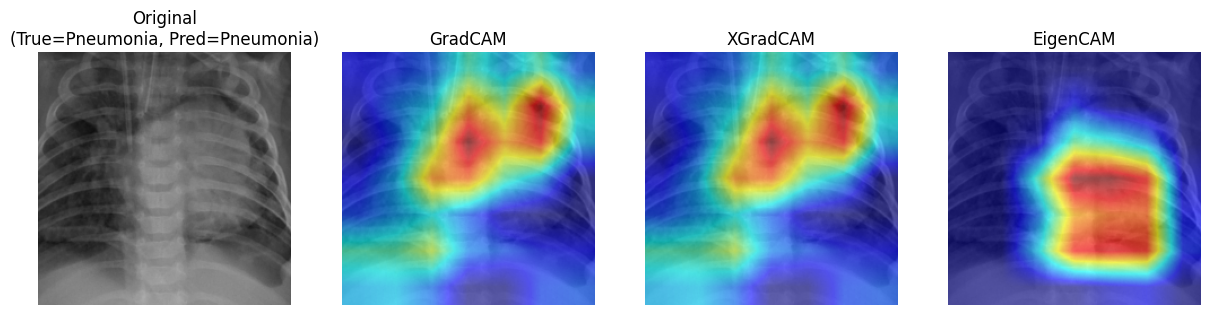

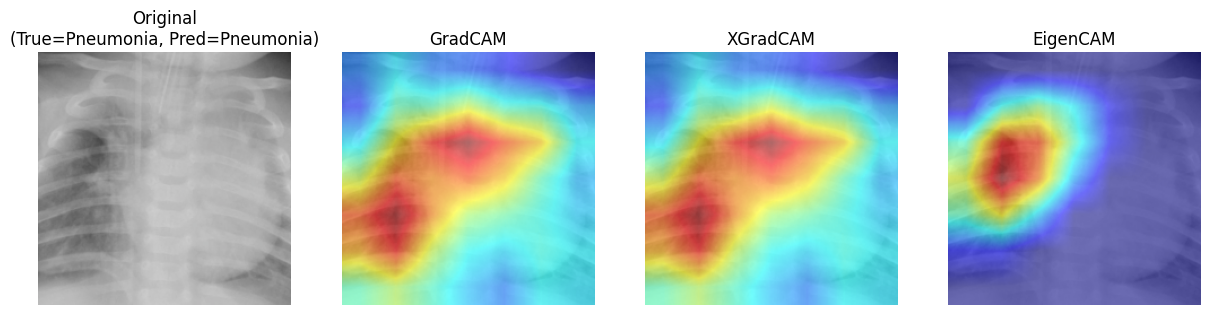

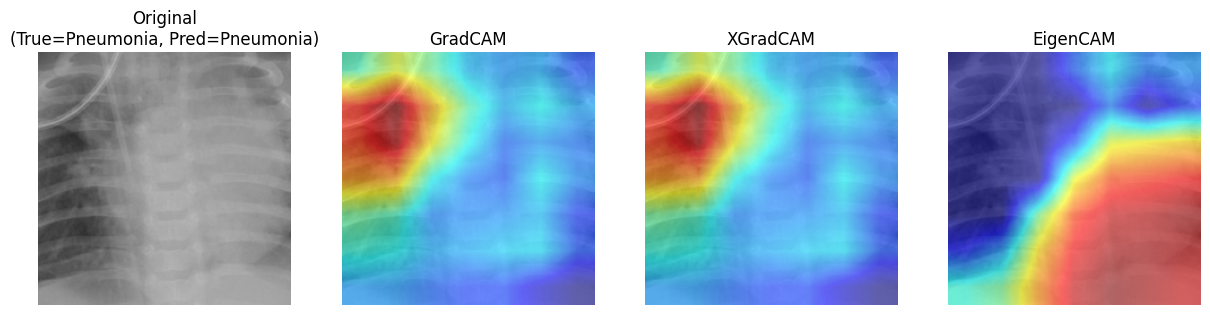

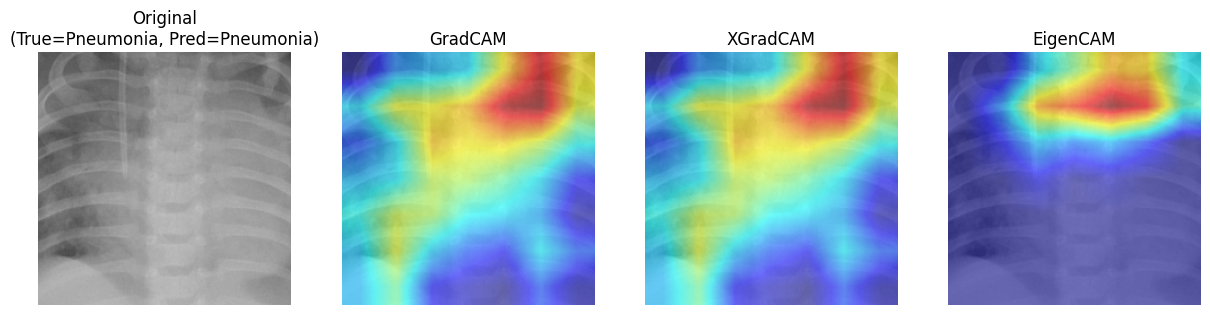

In [17]:
# Setup CAMs
# The last residual block in the last ResNet stage
target_layer = model.layer4[-1]
cam_methods = {
    "GradCAM": GradCAM(model=model, target_layers=[target_layer]),
    "XGradCAM": XGradCAM(model=model, target_layers=[target_layer]),
    "EigenCAM": EigenCAM(model=model, target_layers=[target_layer])
}

# Collect samples from test_loader
normal_imgs, normal_labels = [], []
pneumonia_imgs, pneumonia_labels = [], []

# Loop through test_loader to get 5 images of each category
for imgs, labels in test_loader:
    for i in range(len(labels)):
        if labels[i].item() == 0 and len(normal_imgs) < 5:  # NORMAL = 0
            normal_imgs.append(imgs[i])
            normal_labels.append(labels[i])
        elif labels[i].item() == 1 and len(pneumonia_imgs) < 5:  # PNEUMONIA = 1
            pneumonia_imgs.append(imgs[i])
            pneumonia_labels.append(labels[i])

    if len(normal_imgs) == 5 and len(pneumonia_imgs) == 5:
        break

# Combine into one tensor
images = torch.stack(normal_imgs + pneumonia_imgs)
labels = torch.tensor(normal_labels + pneumonia_labels)

# Denormalization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

def denormalize(img_tensor):
    return torch.clamp(inv_normalize(img_tensor), 0, 1)

# Load and plot
device = next(model.parameters()).device
model.eval()
for idx in range(len(images)):
    input_tensor = images[idx].unsqueeze(0).to(device)
    rgb_img = denormalize(images[idx]).permute(1, 2, 0).cpu().numpy()

    with torch.no_grad():
        outputs = model(input_tensor)
        pred = torch.argmax(outputs).item()

    if pred==0:
      pred_label="Noraml"
    else:
      pred_label="Pneumonia"

    if labels[idx]==0:
      true_label="Normal"
    else:
      true_label="Pneumonia"



    fig, axs = plt.subplots(1, len(cam_methods)+1, figsize=(15, 5))
    axs[0].imshow(rgb_img)
    axs[0].set_title(f"Original\n(True={true_label}, Pred={pred_label})")
    axs[0].axis("off")

    # The below code was generated using GPT5 on 10/03/25 at 2:0pm.
    for i, (name, cam_algo) in enumerate(cam_methods.items(), start=1):
        grayscale_cam = cam_algo(input_tensor=input_tensor)[0, :]
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        axs[i].imshow(visualization)
        axs[i].set_title(name)
        axs[i].axis("off")

    plt.show()


# Reflection

## How to interpret chest X-ray images
- On a normal chest X-ray image, the lungs should appear relatively dark because of their air content, with fine vascular markings visible throughout the lung fields.
- In contrast, pneumonia typically presents as cloudy, white opacities in the lungs, indicating areas of inflammation or fluid accumulation
- Disclaimer: I'm not a medical expert, this is a simplified explanation based on publicly available resources.

## Explainable AI
- I used **ResNet-18** as the pretrained model.
- In the cell above, I implemented **GradCAM, XGradCAM, and EigenCAM** on the images, and displayed five examples from each category (normal and pneumonia) along with their predicted labels. The purpose was to observe whether the three XAI methods focus on similar regions within the images.
### Normal
- Among the five images I printed out, only one image was wrongly predicted as pneumonia. **GradCAM, XGradCAM, and EigeCAM all highlighted the same region of the images, showing that the model consistently relied on this area for making decision**, even though it led to a misclassification.
- Although the attention maps can reveal stable patterns of the model focus, **they do not guarantee correct predictions. This indicates that it is still importance to combine AI explainability with expert annotation**.
### Pneumonia
- The model achieved a high accuracy of 0.98 in predicting pneumonia cases and among the five sample images I printed, all were correctly classified as pneumonia.
- However, the three XAI methods sometimes showed different focus on the images.
- Take the forth pneumonia x-ray image as example:
  - GradCAM and XGradCAM both highlighted the central to left chest region.
  - EigenCAM focused instead on the lower right area, not even overlap with GradCAm and XGradCAM.
  - The difference might come from GradCAM and XGradCAM are gradient-based, they would highlight regions where changes in activation strongly influence the final prediction. However, EigenCAM is activation-based, it tends to highlight regions of high variance or distinctive features.
- When observing other images, we can also see that GradCAm and XGradCAM tended to focus on the similar region and what EigenCAM focused was sometimes different.
- **To tell that if the highlighted region is correct, we need to involve a human expert in the loop and this again highlight the importance of combining AI explainability with expert annotation.**
- **However, from an overall perspective, in the five images, at least one of the three XAI methods in each image consistently highlighted the correct visibly white regions associated with pneumonia.**

## Why model explainability is important?
- There are lots of research and applications building deep learning models for detecting pneumonia through chest X-ray images. **However without XAI methods, the model remains as a black box and we do not know if their decision-making process is reasonable or not.**
- These XAI methods enhance transparency by showing which lung regions the model attends to, this **helps clinicians understand the reasons behind AI's decisions**.
- Doctor are more likely to trust and rely on these AI detection tools when they can verify that the model is focusing on the correct areas.
- In the healthcare domain, an incorrect prediction can delay or misguide treatment. **Explainability ensures that both correct and incorrect predictions can be inspected.**






